# Artificial network generation 2.0

In [1]:
import numpy as np
import pandas as pd
import sys
import joblib
sys.path.insert(0, "./scripts")
import functions as f
from copy import deepcopy
import networkx as nx
from collections import namedtuple
from itertools import product, combinations
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
from time import sleep
%load_ext autoreload
%autoreload 2

In [2]:
cfg = f.get_actual_parametrization("./config.json")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


# Yeast Tnet

In [3]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "yeast")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


In [4]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [5]:
%%time
motifs, counter = f.motif_search(cfg, interaction_matrix, batch_size=10000)
motifs_orig = motifs["030T"]
counter

CPU times: user 2.53 s, sys: 141 ms, total: 2.67 s
Wall time: 8.08 s


{'021C': 37631, '021D': 1059856, '021U': 26042, '030C': 8, '030T': 3370}

In [6]:
ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in motifs_orig], [])))
interaction_matrix_ffl = np.zeros((len(ffl_nodes), len(ffl_nodes)))
for motif in motifs_orig:
    motif = f.split_motif(motif)
    motif_new = list(ffl_nodes.index(x) for x in motif)
    interaction_matrix_ffl[np.ix_(motif_new, motif_new)] = \
    interaction_matrix[np.ix_(motif, motif)]
interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

((1201, 1201), 4326.0)

In [7]:
4326/1201

3.6019983347210656

In [104]:
tf_nodes = np.where(interaction_matrix_ffl.sum(axis=0) != 0)[0]
tg_nodes = np.where(interaction_matrix_ffl.sum(axis=0) == 0)[0]
len(tf_nodes), len(tg_nodes), len(tf_nodes)/interaction_matrix_ffl.shape[0]

(123, 1078, 0.10241465445462115)

In [105]:
%%time
motifs, counter = f.motif_search(cfg, interaction_matrix_ffl, batch_size=10000)
motifs_ffl = motifs["030T"]
counter

CPU times: user 361 ms, sys: 74.6 ms, total: 435 ms
Wall time: 1.96 s


{'021C': 12874, '021D': 170539, '021U': 6906, '030C': 8, '030T': 3370}

In [109]:
types = pd.Series([len(set(f.split_motif(x)) - set(tf_nodes)) for x in motifs_ffl])

In [112]:
types.value_counts(normalize=True)

1    0.950445
0    0.049555
dtype: float64

In [69]:
interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

((1201, 1201), 6471.0)

In [70]:
6471/1201

5.388009991673606

In [71]:
edges = []
for triad in motifs_ffl:
    for x in combinations(f.split_motif(triad), 2):
        edges.append("_".join(map(str, sorted(x))))
len(edges), len(set(edges))

(10110, 4326)

In [31]:
def get_network_params(interaction_matrix, verbose=True):
    # motif search
    motifs, counter = f.motif_search(
        cfg, interaction_matrix, batch_size=10000, verbose=False
    )
    motifs = motifs["030T"]
    # TF/TG recognition
    tf_nodes = np.where(interaction_matrix.sum(axis=0) != 0)[0]
    tg_nodes = np.where(interaction_matrix.sum(axis=0) == 0)[0]
    # motif type distribution
    n_tg_nodes_list = np.array(
        [len(set(f.split_motif(motif)) - set(tf_nodes)) for motif in motifs]
    )
    mtype_probs = pd.Series(n_tg_nodes_list).value_counts(normalize=True).sort_index()
    if verbose:
        print("Number of TG in motif distribution:")
        print(mtype_probs)
        print()
    # nodes participation in FFL
    node_part = np.zeros(interaction_matrix.shape[0])
    for triad in motifs:
        for x in map(int, triad.split("_")):
            node_part[x] += 1
    node_part = pd.Series(node_part)
    if verbose:
        print("Node patricipation distribution:")
        print(node_part.value_counts(normalize=False).head())
        print(node_part.value_counts(normalize=True).head())
        print()
    # Distribution of X-unique nodes motifs number
    edges_1 = []
    motifs_0 = []
    types = {i: 0 for i in range(3)}
    for triad in motifs:
        res = 0
        i = 0
        for x in map(int, triad.split("_")):
            res += node_part[x] == 1
            if node_part[x] == 1:
                i = x
        types[res] += 1
        if res == 1:
            edges_1.append(set(f.split_motif(triad))-set([i]))
        if res == 0:
            motifs_0.append(triad)
    types = pd.Series(types)
    unique_nodes = types/sum(types)
    if verbose:
        print("Unique nodes number distribution")
        print(types)
        print(unique_nodes)
        print()
    #  Is edge unique? (for 1-unique node motifs)
    edges_1_part = {"_".join(map(str, sorted(edge))): 0 for edge in edges_1}
    for triad in motifs:
        for x in combinations(f.split_motif(triad), 2):
            edge_1 = "_".join(map(str, sorted(x)))
            try:
                edges_1_part[edge_1] += 1
            except KeyError:
                pass
    edges_1_part = pd.Series(edges_1_part)
    unique_edges_1 = (edges_1_part == 1).value_counts(normalize=True)
    if verbose:
        print("Is edge unique? (for 1-unique node motifs)")
        print((edges_1_part == 1).value_counts())
        print(unique_edges_1)
        print()
    # Distribution of X-unique edges motifs (for 0-unique nodes motifs)
    edges_0_part = {}
    for triad in motifs_0:
        for x in combinations(f.split_motif(triad), 2):
            edge_0 = "_".join(map(str, sorted(x)))
            try:
                edges_0_part[edge_0] += 1
            except KeyError:
                edges_0_part[edge_0] = 1
    edges_0_part = pd.Series(edges_0_part)
    edge_types = {i: 0 for i in range(4)}
    for triad in motifs_0:
        res = 0
        for x in combinations(f.split_motif(triad), 2):
            edge_0 = "_".join(map(str, sorted(x)))
            res += edges_0_part[edge_0] == 1
        edge_types[res] += 1
    edge_types = pd.Series(edge_types)
    unique_edges_0 = edge_types/sum(edge_types)
    if verbose:
        print("Distribution of X-unique edges motifs (for 0-unique nodes motifs)")
        print(edge_types)
        print(unique_edges_0)
        print()
    Params = namedtuple(
        "Params", "substrate_motifs tf_nodes tg_nodes mtype_probs unique_nodes unique_edges_1 unique_edges_0"
    )
    params = Params(
        *[motifs, tf_nodes, tg_nodes, mtype_probs, unique_nodes, unique_edges_1, unique_edges_0]
    )
    return params

In [316]:
def get_attachment_params(params):
    """
    Selection of inner/outer motifs and number of shared nodes
    ________________________________________________________________________
    params - network parameters from previous stage of analysis (see get_network_params)
    """
    
    # number of unique nodes in the outer motif
    unique_nodes = params.unique_nodes.loc[[0, 1]]
    unique_nodes = unique_nodes/sum(unique_nodes)
    n_unique_nodes = np.random.choice(
        unique_nodes.index, p=unique_nodes.values
    )
#     n_unique_nodes = np.random.choice(
#         params.unique_nodes.index, p=params.unique_nodes.values
#     )
    # number of unique edges in the outer motif
    n_unique_edges = None
    if n_unique_nodes == 1:
        n_unique_edges = 0
#         n_unique_edges = int(np.random.choice(
#             params.unique_edges_1.index, p=params.unique_edges_1.values
#         ))
    elif n_unique_nodes == 0:
        unique_edges_0 = params.unique_edges_0.loc[[1, 2]]
        unique_edges_0 = unique_edges_0/sum(unique_edges_0)
        n_unique_edges = int(np.random.choice(
            unique_edges_0.index, p=unique_edges_0.values
        ))
#         n_unique_edges = int(np.random.choice(
#             params.unique_edges_0.index, p=params.unique_edges_0.values
#         ))
    # buiding VMN for motifs
    substrate_vmn = f.build_vmn(params.substrate_motifs)    
    
    # motif selection for 1 node/2 edges attachment case
    if n_unique_nodes == 1 and n_unique_edges == 0:
        substrate_type_idxs = list(range(len(params.substrate_motifs)))
        substrate_type_vmn = substrate_vmn
        weights = substrate_type_vmn.sum(axis=1)
        weights /= sum(weights)
        inner_motif_1_idx = np.random.choice(substrate_type_idxs, p=weights)
        inner_motif_2_idx = None
    # motif selection for 0 nodes/1 edges attachment case
    elif n_unique_nodes == 0 and n_unique_edges == 1:
        substrate_type_idxs = np.where((substrate_vmn==1)|(substrate_vmn==2))[0]
        substrate_type_vmn = substrate_vmn[substrate_type_idxs, :]
        weights = substrate_type_vmn.sum(axis=1)
        weights /= sum(weights)
        inner_motif_1_idx = np.random.choice(substrate_type_idxs, p=weights)
        line = substrate_vmn[inner_motif_1_idx, :]
        inner_motif_2_idx = np.random.choice(np.where((line==1)|(line==2))[0])   
    # motif selection for 0 nodes/2 edges attachment case
    elif n_unique_nodes == 0 and n_unique_edges == 2:
        substrate_type_idxs = np.where((substrate_vmn==1)|(substrate_vmn==0))[0]
        substrate_type_vmn = substrate_vmn[substrate_type_idxs, :]
        weights = substrate_type_vmn.sum(axis=1)
        weights /= sum(weights)
        inner_motif_1_idx = np.random.choice(substrate_type_idxs, p=weights)
        line = substrate_vmn[inner_motif_1_idx, :]
        inner_motif_2_idx = np.random.choice(np.where((line==1)|(line==0))[0])
    # determine types 
    intype_1 = len(set(f.split_motif(params.substrate_motifs[inner_motif_1_idx])) - set(params.tf_nodes))
    if inner_motif_2_idx is not None:
        intype_2 = len(set(f.split_motif(params.substrate_motifs[inner_motif_2_idx])) - set(params.tf_nodes))
    else:
        intype_2 = None
    
    # incoming motif type selection
    outtype = np.random.binomial(1, p=0.5)

    # results packing
    Params = namedtuple(
        "Params", "substrate_motifs inner_motif_1_idx inner_motif_2_idx intype_1 intype_2 outtype n_unique_nodes n_unique_edges"
    )
    params = Params(
        *[params.substrate_motifs, inner_motif_1_idx, inner_motif_2_idx, intype_1, intype_2, outtype, n_unique_nodes, n_unique_edges]
    )
    return params

In [308]:
%%time
params = param_estimation(interaction_matrix_ffl)

Number of TG in motif distribution:
0    0.051632
1    0.948368
dtype: float64

Node patricipation distribution:
1.0    0.457952
2.0    0.175687
3.0    0.094088
4.0    0.048293
5.0    0.034138
dtype: float64

Unique nodes number distribution
0    0.837685
1    0.161424
2    0.000890
dtype: float64

Is edge unique? (for 1-unique node motifs)
False    0.968153
True     0.031847
dtype: float64

Distribution of X-unique edges motifs (for 0-unique nodes motifs)
1    1042
2     230
3       6
dtype: int64
1    0.815336
2    0.179969
3    0.004695
dtype: float64

CPU times: user 1.19 s, sys: 139 ms, total: 1.33 s
Wall time: 5.97 s


In [203]:
substrate_matrix = get_network_nucleus(interaction_matrix, motifs_orig, motifs_network, 
                                      min_size=200, random_seed=19)

In [314]:
%%time
network_params = param_estimation(substrate_matrix)

Number of TG in motif distribution:
0    0.123596
1    0.876404
dtype: float64

Node patricipation distribution:
1.0    0.570
2.0    0.080
3.0    0.050
4.0    0.045
7.0    0.040
dtype: float64

Unique nodes number distribution
0    0.755056
1    0.233708
2    0.011236
dtype: float64

Is edge unique? (for 1-unique node motifs)
False    0.886792
True     0.113208
dtype: float64

Distribution of X-unique edges motifs (for 0-unique nodes motifs)
1    57
2    10
3     0
dtype: int64
1    0.850746
2    0.149254
3    0.000000
dtype: float64

CPU times: user 479 ms, sys: 203 ms, total: 682 ms
Wall time: 2.48 s


In [329]:
attachment_params = get_attachment_params(network_params)
attachment_params[1:]

(214, None, 1, None, 0, 1, 0)

# Vertex-based motif network on FFL

In [8]:
motifs_network = f.build_vmn(motifs_orig, verbose=True)

100%|██████████| 5676765/5676765 [00:17<00:00, 327836.73it/s]


In [9]:
V = nx.Graph(motifs_network)
nx.is_connected(V)

True

# Generation algorithm

#### Nucleation
One needs a piece of the real network to get reasonable probability estimates for further preferential attachment workflow

In [10]:
def get_network_nucleus(
    interaction_matrix, motifs, motifs_network, min_size, random_seed=cfg["RANDOM_SEED"]
):
    """
    Getting subsample from real network as a nucleus for artificial network
    ________________________________________________________________________
    interaction_matrix (numpy.array) - binary interaction matrix for genes
    motifs (numpy.array) - list of unique identifiers for condidered motifs (FFL triads)
    motifs_network (numpy.array) - vertex-based motifs network (linkage by shared nodes)
    min_size (int) - minimal required size of resulting nucleus (may be slightly higher eventually)
    random_seed (int) - reproducibility parameter
    
    """
    np.random.seed(random_seed)
    substrate_motif_idxs = [np.random.randint(len(motifs))]
    substrate_motifs = np.array([motifs[i] for i in substrate_motif_idxs])
    substrate_size = len(set(sum([f.split_motif(motif) for motif in substrate_motifs], [])))

    # grow network nucleus while required size obtained
    while substrate_size < min_size:
        neighbors = np.where(motifs_network[:, substrate_motif_idxs].sum(axis=1) != 0)[0]
        neighbors = np.array(list(set(neighbors) - set(substrate_motif_idxs)))
        # assignment of weights to candidate motifs by their connectivity
        # with already selected motifs grown substrate network
        weights = motifs_network[neighbors, :][:, substrate_motif_idxs].sum(axis=1)
        weights /= sum(weights)
        substrate_motif_idxs.append(np.random.choice(neighbors, size=1, p=weights)[0])
        substrate_motifs = np.array([motifs[i] for i in substrate_motif_idxs])
        substrate_size = len(set(sum([f.split_motif(motif) for motif in substrate_motifs], [])))

    # interaction matrix building
    G = nx.DiGraph()
    for motif in substrate_motifs:
        nodes = f.split_motif(motif)
        M = nx.DiGraph(interaction_matrix[nodes, :][:, nodes])
        M = nx.relabel_nodes(M, mapping={i: node for i, node in enumerate(nodes)})
        G = nx.compose(G, M)
    substrate_matrix = nx.convert_matrix.to_numpy_array(G)
    return substrate_matrix

#### Parametrization
Motif types and number of shared nodes distributions inference. 

The support set for FFL motif type by TF/TG content is {TTT, TTG} where T and G are for TF and TG respectively.

The support set for the number of shared nodes is {1, 2}. We are not considering 0 as we focus only on the largest connected component of FFL VMN which actually contains all of the FFLs in the yeast Tnet and nearly all (99%) in E.coli Tnet

In [11]:
def get_network_params(interaction_matrix, verbose=True):
    # motif search
    motifs, counter = f.motif_search(
        cfg, interaction_matrix, batch_size=10000, verbose=False
    )
    motifs = motifs["030T"]
    # TF/TG recognition
    tf_nodes = np.where(interaction_matrix.sum(axis=0) != 0)[0]
    tg_nodes = np.where(interaction_matrix.sum(axis=0) == 0)[0]
    # motif type distribution
    n_tg_nodes_list = np.array(
        [len(set(f.split_motif(motif)) - set(tf_nodes)) for motif in motifs]
    )
    mtype_probs = pd.Series(n_tg_nodes_list).value_counts(normalize=True).sort_index()
    if verbose:
        prob = len(tf_nodes)/interaction_matrix.shape[0]
        print(f"TF content: {prob}")
        print("Number of TG in motif distribution:")
        print(mtype_probs)
        print()
    # nodes participation in FFL
    node_part = np.zeros(interaction_matrix.shape[0])
    for triad in motifs:
        for x in map(int, triad.split("_")):
            node_part[x] += 1
    node_part = pd.Series(node_part)
    if verbose:
        print("Node patricipation distribution:")
        print(node_part.value_counts(normalize=True).head())
        print()
    # Distribution of X-unique nodes motifs number
    edges_1 = []
    motifs_0 = []
    types = {i: 0 for i in range(3)}
    for triad in motifs:
        res = 0
        i = 0
        for x in map(int, triad.split("_")):
            res += node_part[x] == 1
            if node_part[x] == 1:
                i = x
        types[res] += 1
        if res == 1:
            edges_1.append(set(f.split_motif(triad))-set([i]))
        if res == 0:
            motifs_0.append(triad)
    types = pd.Series(types)
    unique_nodes = types/sum(types)
    if verbose:
        print("Unique nodes number distribution")
        print(unique_nodes)
        print()
    #  Is edge unique? (for 1-unique node motifs)
    edges_1_part = {"_".join(map(str, sorted(edge))): 0 for edge in edges_1}
    for triad in motifs:
        for x in combinations(f.split_motif(triad), 2):
            edge_1 = "_".join(map(str, sorted(x)))
            try:
                edges_1_part[edge_1] += 1
            except KeyError:
                pass
    edges_1_part = pd.Series(edges_1_part)
    unique_edges_1 = (edges_1_part == 1).value_counts(normalize=True)
    if verbose:
        print("Is edge unique? (for 1-unique node motifs)")
        print(unique_edges_1)
        print()
    # Distribution of X-unique edges motifs (for 0-unique nodes motifs)
    edges_0_part = {}
    for triad in motifs_0:
        for x in combinations(f.split_motif(triad), 2):
            edge_0 = "_".join(map(str, sorted(x)))
            try:
                edges_0_part[edge_0] += 1
            except KeyError:
                edges_0_part[edge_0] = 1
    edges_0_part = pd.Series(edges_0_part)
    edge_types = {i: 0 for i in range(4)}
    for triad in motifs_0:
        res = 0
        for x in combinations(f.split_motif(triad), 2):
            edge_0 = "_".join(map(str, sorted(x)))
            res += edges_0_part[edge_0] == 1
        edge_types[res] += 1
    edge_types = pd.Series(edge_types)
    unique_edges_0 = edge_types/sum(edge_types)
    if verbose:
        print("Distribution of X-unique edges motifs (for 0-unique nodes motifs)")
        print(edge_types)
        print(unique_edges_0)
        print()
    Params = namedtuple(
        "Params", "substrate_motifs tf_nodes tg_nodes mtype_probs unique_nodes unique_edges_1 unique_edges_0"
    )
    params = Params(
        *[motifs, tf_nodes, tg_nodes, mtype_probs, unique_nodes, unique_edges_1, unique_edges_0]
    )
    return params

#### Single attachment step

Random selection of the inner/outer motif types and number of shared nodes with probabilities from the previous step

In [22]:
def get_attachment_params(substrate_matrix, params, growth_pace=None):
    """
    Selection of inner/outer motifs and number of shared nodes
    ________________________________________________________________________
    params - network parameters from previous stage of analysis (see get_network_params)
    """
    
    # number of unique nodes in the outer motif
    unique_nodes = params.unique_nodes.loc[[0, 1]]
    unique_nodes = unique_nodes/sum(unique_nodes)
    if growth_pace is not None:
        unique_nodes[1] = growth_pace
        unique_nodes[0] = 1 - growth_pace
    n_unique_nodes = np.random.choice(
        unique_nodes.index, p=unique_nodes.values
    )
#     n_unique_nodes = np.random.choice(
#         params.unique_nodes.index, p=params.unique_nodes.values
#     )
    # number of unique edges in the outer motif
    n_unique_edges = None
    if n_unique_nodes == 1:
        n_unique_edges = 0
#         n_unique_edges = int(np.random.choice(
#             params.unique_edges_1.index, p=params.unique_edges_1.values
#         ))
    elif n_unique_nodes == 0:
        unique_edges_0 = params.unique_edges_0.loc[[1, 2]]
        unique_edges_0 = unique_edges_0/sum(unique_edges_0)
        n_unique_edges = int(np.random.choice(
            unique_edges_0.index, p=unique_edges_0.values
        ))
#         n_unique_edges = int(np.random.choice(
#             params.unique_edges_0.index, p=params.unique_edges_0.values
#         ))
    # buiding VMN for motifs
    substrate_vmn = f.build_vmn(params.substrate_motifs)    
    
    # motif selection for 1 node/2 edges attachment case
    if n_unique_nodes == 1 and n_unique_edges == 0:
        substrate_type_idxs = list(range(len(params.substrate_motifs)))
        substrate_type_vmn = substrate_vmn
        weights = substrate_type_vmn.sum(axis=1)
        weights /= sum(weights)
        inner_motif_1_idx = np.random.choice(substrate_type_idxs, p=weights)
        inner_motif_2_idx = None
    # motif selection for 0 nodes/1 edges attachment case
    elif n_unique_nodes == 0 and n_unique_edges == 1:
        substrate_type_idxs = np.where((substrate_vmn==1)|(substrate_vmn==2))[0]
        substrate_type_vmn = substrate_vmn[substrate_type_idxs, :]
        weights = substrate_type_vmn.sum(axis=1)
        weights /= sum(weights)
        while True:
#             inner_motif_1_idx = np.random.choice(substrate_type_idxs, p=weights)
            inner_motif_1_idx = np.random.choice(substrate_type_idxs)
            line = substrate_vmn[inner_motif_1_idx, :]
            inner_motif_2_idx = np.random.choice(np.where((line==1)|(line==2))[0])
            # check if there at least one pair of nodes with no link between
            inner_motif_1 = f.split_motif(params.substrate_motifs[inner_motif_1_idx])
            inner_motif_2 = f.split_motif(params.substrate_motifs[inner_motif_2_idx])
            indecies = list(set(inner_motif_1) | set(inner_motif_2))
            a = substrate_matrix[indecies, :][:, indecies]
            if not (a + a.T + np.diag([1]*a.shape[0]) == 1).all():
                break

    # motif selection for 0 nodes/2 edges attachment case
    elif n_unique_nodes == 0 and n_unique_edges == 2:
        substrate_type_idxs = np.where((substrate_vmn==1)|(substrate_vmn==0))[0]
        substrate_type_vmn = substrate_vmn[substrate_type_idxs, :]
        weights = substrate_type_vmn.sum(axis=1)
        weights /= sum(weights)
        while True:
#             inner_motif_1_idx = np.random.choice(substrate_type_idxs, p=weights)
            inner_motif_1_idx = np.random.choice(substrate_type_idxs)
            line = substrate_vmn[inner_motif_1_idx, :]
            inner_motif_2_idx = np.random.choice(np.where((line==1)|(line==0))[0])
            # check if there at least one node with no links with two others
            inner_motif_1 = f.split_motif(params.substrate_motifs[inner_motif_1_idx])
            inner_motif_2 = f.split_motif(params.substrate_motifs[inner_motif_2_idx])
            indecies = list(set(inner_motif_1) | set(inner_motif_2))
            a = substrate_matrix[indecies, :][:, indecies]
            b = a + a.T; b
            if sum(np.array([b.shape[0] - np.count_nonzero(x) for x in b]) >= 3):
                break
        
    # determine types 
    intype_1 = len(set(f.split_motif(params.substrate_motifs[inner_motif_1_idx])) - set(params.tf_nodes))
    if inner_motif_2_idx is not None:
        intype_2 = len(set(f.split_motif(params.substrate_motifs[inner_motif_2_idx])) - set(params.tf_nodes))
    else:
        intype_2 = None
    # incoming motif type selection
    outtype = np.random.binomial(1, p=0.5)
#     outtype = np.random.binomial(1, p=len(params.tg_nodes)/substrate_matrix.shape[0])
    # results packing
    Params = namedtuple(
        "Params", "substrate_motifs inner_motif_1_idx inner_motif_2_idx intype_1 intype_2 outtype n_unique_nodes n_unique_edges"
    )
    params = Params(
        *[params.substrate_motifs, inner_motif_1_idx, inner_motif_2_idx, intype_1, intype_2, outtype, n_unique_nodes, n_unique_edges]
    )
    return params

Now is the most tricky part. 

Selection an attachment pattern by the inner/outer motif types and the number of shared nodes fixed on the previous step. The approach strongly depends on the number of shared nodes

Shared node case

<img src="./pics/shared_node_pattern.png" width=600 height=20/>

After a thorough investigation we concluded the following list of patterns:

(inner motif type / outer motif type / isoforms number)

- TTT / TTT - 9 variants
- TTT / TTG - 6 variants
- TTG / TTT - 6 variants
- TTG / TTG - 5 variants

In [23]:
def get_attachment_matrix_shared_node(substrate_matrix, params):
    """
    Attachment patterns constructing for shared node case and random selection the particular one
    ________________________________________________________________________
    substrate_matrix - the netwotk we are growing
    params - attachment parameters from previous stage of analysis (see get_attachment_params)
    """
    inner_motif = f.split_motif(params.substrate_motifs[params.inner_motif_idx])
    inner_motif_matrix = substrate_matrix[inner_motif, :][:, inner_motif]
    outer_motif_matrix = f.build_motif_from_string("0 1 1 0 0 1 0 0 0")
    # check if there are target genes in the considered motifs
    tg_in = inner_motif_matrix.sum(axis=0).argmin() if params.intype == 1 else None
    tg_out = outer_motif_matrix.sum(axis=0).argmin() if params.outtype == 1 else None
    patterns = [] # accumulator of appropriate pattern
    for idx_in, role_out in product(*[range(3)]*2):
        # filtering out inappropriate patterns (by target gene )
        if (idx_in != tg_in) & (role_out == tg_out):
            continue
        if (idx_in == tg_in) & (role_out != tg_out):
            continue
        I = nx.DiGraph(inner_motif_matrix)
        O = nx.DiGraph(outer_motif_matrix)
        mapping = {i: i+3 for i in range(3)}
        mapping[role_out] = idx_in
        O = nx.relabel_nodes(O, mapping=mapping)
        C = nx.compose(I, O)
        compounded_matrix = nx.convert_matrix.to_numpy_array(C)
        patterns.append(compounded_matrix)
    attachment_matrix = patterns[np.random.randint(len(patterns))]
    return attachment_matrix

#### Attach 1 node and 2 edges

<img src="./pics/shared_edge_pattern.png" width=600 height=20/>

Results of isoforms diversity analysis:

(inner motif type / outer motif type / isoforms number)

- TTT / TTT - 9 variants
- TTT / TTG - 3 variants
- TTG / TTT - 3 variants
- TTG / TTG - 5 variants

In [24]:
def get_outer_motif_matrix(role_edge):
    """
    Selection of incoming motif matrix based on shared edge type
    """
    if role_edge == (2, 1):
        return f.build_motif_from_string("0 1 1 0 0 0 0 1 0")
    if role_edge == (2, 0):
        return f.build_motif_from_string("0 1 0 0 0 0 1 1 0")
    if role_edge == (1, 0):
        return f.build_motif_from_string("0 0 0 1 0 0 1 1 0")

In [25]:
def get_attachment_1n2e(substrate_matrix, params):
    """
    Attachment patterns constructing for shared edge case and random selection the particular one
    ________________________________________________________________________
    substrate_matrix - the netwotk we are growing
    params - attachment parameters from previous stage of analysis (see get_attachment_params)
    """
    tg_total = np.where(substrate_matrix.sum(axis=0) == 0)[0]
    inner_motif = f.split_motif(params.substrate_motifs[params.inner_motif_1_idx])
    inner_motif_matrix = substrate_matrix[inner_motif, :][:, inner_motif]
    inner_nodes_roles = list(inner_motif_matrix.sum(axis=0).astype(int))
    # check if there is a target gene
    tg_in = inner_nodes_roles.index(0) if params.intype_1 == 1 else None
    # assignment roles and corresponding identifiers to the edges
    role_edges = list(combinations(range(2, -1, -1), 2))
    idx_by_role = lambda x: inner_nodes_roles.index(x)
    idx_edges_in = [(idx_by_role(source), idx_by_role(target)) for source, target in role_edges]
    patterns = []
    
    prob = len(tg_total)/substrate_matrix.shape[0]
    if params.outtype == 1:
        append_gene = np.random.binomial(1, p=prob*(2-prob))
    else:
        append_gene = np.random.binomial(1, p=prob)

    for idx_edge_in, role_edge_out in product(idx_edges_in, role_edges):
        outer_motif_matrix = get_outer_motif_matrix(role_edge_out)
        outer_nodes_roles = list(outer_motif_matrix.sum(axis=0).astype(int))
        # reveal positions by known edges roles
        idx_by_role = lambda x: outer_nodes_roles.index(x)
        idx_edge_out = tuple(idx_by_role(v) for v in role_edge_out)
        # check if there is a target gene
        tg_out = outer_motif_matrix.sum(axis=0).argmin() if params.outtype == 1 else None
        
        if tg_out is not None and tg_out not in idx_edge_out and not append_gene:
            continue
        
        if append_gene and not(tg_out is not None and tg_out not in idx_edge_out):
            continue
        
        # filtering out inappropriate patterns (by target gene )
        if (idx_edge_in[0] != tg_in) & (idx_edge_out[0] == tg_out):
            continue
        if (idx_edge_in[0] == tg_in) & (idx_edge_out[0] != tg_out):
            continue
        if (idx_edge_in[1] != tg_in) & (idx_edge_out[1] == tg_out):
            continue
        if (idx_edge_in[1] == tg_in) & (idx_edge_out[1] != tg_out):
            continue
        I = nx.DiGraph(inner_motif_matrix)
        O = nx.DiGraph(outer_motif_matrix)
        mapping = {i: i+3 for i in range(3)}
        mapping[1], mapping[2] = idx_edge_in
        O = nx.relabel_nodes(O, mapping=mapping)
        C = nx.compose(I, O)
        compounded_matrix = nx.convert_matrix.to_numpy_array(C)
        patterns.append(compounded_matrix)
    if patterns:
        attachment_matrix = patterns[np.random.randint(len(patterns))]
    else:
        attachment_matrix = None
    return attachment_matrix

#### Attach 0 nodes and 1 edge

In [26]:
def prepare_motif_libs():
    dl_lib = [
        "".join(map(str, x.flatten().astype(int))) for x in
        f.get_equivalents(f.build_motif_from_string("0 0 0 1 0 0 1 0 0"))
    ]
    ul_lib = [
        "".join(map(str, x.flatten().astype(int))) for x in
        f.get_equivalents(f.build_motif_from_string("0 1 1 0 0 0 0 0 0"))
    ]
    cs_lib = [
        "".join(map(str, x.flatten().astype(int))) for x in
        f.get_equivalents(f.build_motif_from_string("0 1 0 0 0 0 1 0 0"))
    ]
    return dl_lib, ul_lib, cs_lib

In [27]:
def get_attachment_0n1e(substrate_matrix, params):
    """
    Attachment patterns constructing for one edge attachment case 
    and random selection the particular one
    ________________________________________________________________________
    substrate_matrix - the netwotk we are growing
    params - attachment parameters from previous stage of analysis (see get_attachment_params)
    """
    dl_lib, ul_lib, cs_lib = prepare_motif_libs()
    inner_motif_1 = f.split_motif(params.substrate_motifs[params.inner_motif_1_idx])
    inner_motif_2 = f.split_motif(params.substrate_motifs[params.inner_motif_2_idx])
    tf_total = np.where(substrate_matrix.sum(axis=0) != 0)[0]
    tg_total = np.where(substrate_matrix.sum(axis=0) == 0)[0]
#     print("Motifs:", inner_motif_1, inner_motif_2)
    # if there tg nodes in this motif pair
    tg_nodes = (set(inner_motif_1) | set(inner_motif_2)) & set(tg_total)
#     print("TG nodes", tg_nodes)
    # separate nodes by motif they belong to (or both of them)
    shared_nodes = list(set(inner_motif_1) & set(inner_motif_2))
#     print("Shared nodes:", shared_nodes)
    unique_nodes_1 = list(set(inner_motif_1) - set(inner_motif_2))
#     print("Unique nodes 1:", unique_nodes_1)
    unique_nodes_2 = list(set(inner_motif_2) - set(inner_motif_1))
#     print("Unique nodes 2:", unique_nodes_2)    
    # construct all possible triads (common vertex - node in 1st motif - node in 2nd motif)
    triads = product(shared_nodes, product(unique_nodes_1, unique_nodes_2))
    get_type = lambda triad: len(set(triad) - set(tf_total))
    triads = [(x, y, z) for x, (y, z) in triads if get_type((x, y, z))==params.outtype]
#     print(triads)
    # accumulate possible links upon base motif
    possible_links = []
    for triad in triads:
#         print(triad)
        triad_matrix = substrate_matrix[triad, :][:, triad]
        triad_str = "".join(map(str, triad_matrix.flatten().astype(int)))
        node_1, node_2 = triad[1:]
        if triad_str in dl_lib:
#             print("downlink base motif")
#             print(triad_matrix)
            if node_2 not in tg_nodes:
                possible_links.append((node_1, node_2))
            if node_1 not in tg_nodes:
                possible_links.append((node_2, node_1))
        elif triad_str in ul_lib:
#             print("uplink base motif")
#             print(triad_matrix)
            possible_links.append((node_1, node_2))
            possible_links.append((node_2, node_1))
        elif triad_str in cs_lib:
#             print("cascade base motif")
#             print(triad_matrix)
#             print(triad_str, triad_str[3])
            if triad_str[3] == "1":
#                 print(1, node_1, node_2)
                possible_links.append((node_1, node_2))
            else:
                possible_links.append((node_2, node_1))
#         print(possible_links)
    possible_links = list(set(possible_links))
    if possible_links:
        link_to_attach = possible_links[np.random.choice(range(len(possible_links)))]
    else:
        link_to_attach = None
    return link_to_attach

#### Attach 0 nodes and 2 edge

In [28]:
def get_attachment_0n2e(substrate_matrix, params):
    """
    Attachment patterns constructing for two edges attachment case 
    and random selection the particular one
    ________________________________________________________________________
    substrate_matrix - the netwotk we are growing
    params - attachment parameters from previous stage of analysis (see get_attachment_params)
    """
    inner_motif_1 = f.split_motif(params.substrate_motifs[params.inner_motif_1_idx])
    inner_motif_2 = f.split_motif(params.substrate_motifs[params.inner_motif_2_idx])
    tf_total = np.where(substrate_matrix.sum(axis=0) != 0)[0]
    tg_total = np.where(substrate_matrix.sum(axis=0) == 0)[0]
#     print("Motifs:", inner_motif_1, inner_motif_2)
    # if there tg nodes in this motif pair
    tg_nodes = (set(inner_motif_1) | set(inner_motif_2)) & set(tg_total)
#     print("TG nodes", tg_nodes)
    # separate nodes by motif they belong to (or both of them)
    shared_nodes = list(set(inner_motif_1) & set(inner_motif_2))
#     print("Shared nodes:", shared_nodes)
    unique_nodes_1 = list(set(inner_motif_1) - set(inner_motif_2))
#     print("Unique nodes 1:", unique_nodes_1)
    unique_nodes_2 = list(set(inner_motif_2) - set(inner_motif_1))
#     print("Unique nodes 2:", unique_nodes_2)
    # triads construction
    triads = []
    if len(shared_nodes) == 1:
        unique_nodes = [unique_nodes_1, unique_nodes_2]
        for i in range(2):
            y, z =  unique_nodes[i-1]
            for x in unique_nodes[i]:
                # check if there is a place for two new links
                if substrate_matrix[(x, y, z), :][:, (x, y, z)].sum() == 1:
                    triads.append((x, y, z))
    else:
        edges_total = [list(combinations(inner_motif_1, 2)), list(combinations(inner_motif_2, 2))]
        nodes_total = [inner_motif_1, inner_motif_2]
        for i in range(2):
            edges = edges_total[i]
            nodes = nodes_total[i-1]
            for y, z in edges:
                for x in nodes:
                    # check if there is a place for two new links
                    if substrate_matrix[(x, y, z), :][:, (x, y, z)].sum() == 1:
                        triads.append((x, y, z))
    get_type = lambda triad: len(set(triad) - set(tf_total))
    triads = [triad for triad in triads if get_type(triad)==params.outtype]
    possible_link_pairs = []
    for triad in triads:
    #     print(triad)
        triad_matrix = substrate_matrix[triad, :][:, triad]
    #     print(triad_matrix)
        target, source = map(lambda x: x[0], np.where(triad_matrix == 1))
        outer = list(set(range(3)) - set([target, source]))[0]
        triad = tuple(triad[i] for i in [source, target, outer])
    #     print(triad)
        triad_matrix = substrate_matrix[triad, :][:, triad]
    #     print(triad_matrix)
        link_pairs = [
            [(2, 0), (2, 1)], [(2, 0), (1, 2)], [(0, 2), (1, 2)]
        ]
        link_pairs = [
            [(triad[i], triad[j]), (triad[k], triad[l])] for (i, j), (k, l) in link_pairs
            if triad[j] not in tg_nodes and triad[l] not in tg_nodes
        ]
        possible_link_pairs += link_pairs
#     print(len(possible_link_pairs))
#     print(possible_link_pairs)
    if possible_link_pairs:
        link_pair = possible_link_pairs[np.random.choice(range(len(possible_link_pairs)))]
    else:
        link_pair = None
    return link_pair  

#### Update

In [29]:
def update_substrate_matrix(substrate_matrix, attachment_pattern, inner_motif, nodes_attach=False):
    """
    Substrate network update by selected attachment pattern
    ________________________________________________________________________
    substrate_matrix - the netwotk we are growing
    attachment_matrix - randomly selected attachment pattern compatible with chosen params
    inner_motif - inner triad we attach to
    """
    substrate_matrix_upd = deepcopy(substrate_matrix)
    if attachment_pattern is not None:
        if nodes_attach:
            n_nodes_to_join = int(attachment_pattern.shape[0] - 3)
            substrate_matrix_upd = np.concatenate(
                (substrate_matrix_upd, np.zeros((n_nodes_to_join, substrate_matrix_upd.shape[1]))), axis=0
            )
            substrate_matrix_upd = np.concatenate(
                (substrate_matrix_upd, np.zeros((substrate_matrix_upd.shape[0], n_nodes_to_join))), axis=1
            )
            shape = substrate_matrix_upd.shape[0]
            # interaction matrix update
            substrate_matrix_upd[
                np.ix_(range(shape-n_nodes_to_join, shape), range(shape-n_nodes_to_join, shape))
            ] = attachment_pattern[np.ix_(range(3, 3+n_nodes_to_join) ,range(3, 3+n_nodes_to_join))]
            substrate_matrix_upd[
                np.ix_(range(shape-n_nodes_to_join, shape), inner_motif)
            ] = attachment_pattern[np.ix_(range(3, 3+n_nodes_to_join) ,range(3))]
            substrate_matrix_upd[
                np.ix_(inner_motif, range(shape-n_nodes_to_join, shape))
            ] = attachment_pattern[np.ix_(range(3), range(3, 3+n_nodes_to_join))]
        else:
            try:
                (i, j), (k, l) = attachment_pattern
                substrate_matrix_upd[i, j] = 1
                substrate_matrix_upd[k, l] = 1
            except TypeError:
                i, j = attachment_pattern
                substrate_matrix_upd[i, j] = 1
    return substrate_matrix_upd

# Stack all in the pipeline

In [30]:
def generate_artificial_network(
    interaction_matrix, 
    motifs=None, 
    motifs_network=None, 
    nucleus_size=50,
    growth_pace=None,
    network_size = 1000,
    reference_matrix=None,
    random_seed=cfg["RANDOM_SEED"]
):
    """
    Aggragated pipeline of artificial network generation
    ________________________________________________________________________
    interaction_matrix (numpy.array) 
        Binary interaction matrix for genes
    motifs (numpy.array, default=None) 
        List of unique identifiers for condidered motifs (FFL triads). 
        If None motif counting is launched
    motifs_network (numpy.array, default=None) 
        Vertex-based motifs network (linkage by shared nodes)
        If None VMN buiding algorithm is launched
    nucleus_size (int, default=50)
        Minimal required size of initial nucleus. 
        The resulting size may be slightly higher as we may attach two nodes per time.
    network_size (int, default=1000)
        Required resulting network size.
        The resulting size may be slightly higher as we may attach two nodes per time.
    random_seed (int, default=19)
        Reproducibility parameter
    """
    assert (motifs is None) & (motifs_network is None) | (motifs is not None)
    np.random.seed(random_seed)
    init_time = datetime.now()
    
    # check if motifs are provided and search them otherwise 
    if motifs is None:
        print("Motifs are not provided. Motif search is in progress...")
        motifs_orig, counter_orig = f.motif_search(
            cfg, interaction_matrix, batch_size=10000, verbose=False
        )
        motifs = motifs_orig["030T"]
        print()
    
    # check if motifs are provided and search them otherwise 
    if motifs_network is None:
        print("Vertex-based FFL net is not provided. VMN building is in progress...")
        motifs_network = f.build_vmn(motifs, verbose=False)
        print()
    
    # nucleus subsampling
    substrate_matrix = get_network_nucleus(
        interaction_matrix, motifs, motifs_network, min_size=nucleus_size
    )
    print(f"Nucleus matrix shape: {substrate_matrix.shape}")
    network_params = get_network_params(substrate_matrix, verbose=True)
    print()
    if reference_matrix is not None:
        print("Reference matrix params")
        fix_network_params = get_network_params(reference_matrix, verbose=True)
        print()
    else:
        fix_network_params = None
    sleep(2)
    # preferencial attachment start
    substrate_size = substrate_matrix.shape[0]
#     pbar_nodes = tqdm(initial=substrate_size, total=network_size)
#     pbar_edges = tqdm(initial=substrate_matrix.sum())
    i = 0
    while substrate_size < network_size:
        i += 1
        network_params = get_network_params(substrate_matrix, verbose=False)
        if fix_network_params is not None: 
            Params = namedtuple(
                "Params", "substrate_motifs tf_nodes tg_nodes mtype_probs unique_nodes unique_edges_1 unique_edges_0"
            )
            network_params = Params(
                *[network_params.substrate_motifs,
                  network_params.tf_nodes,
                  network_params.tg_nodes,
                  fix_network_params.mtype_probs,
                  fix_network_params.unique_nodes,
                  fix_network_params.unique_edges_1,
                  fix_network_params.unique_edges_0]
            )
        params = get_attachment_params(substrate_matrix, network_params, growth_pace=growth_pace)
#         print(params[-5:])
        if params.n_unique_nodes == 1:
            attachment_pattern = get_attachment_1n2e(substrate_matrix, params)
#             n_edges_to_join = 2
        elif params.n_unique_nodes == 0 and params.n_unique_edges == 1:
            attachment_pattern = get_attachment_0n1e(substrate_matrix, params)
#             n_edges_to_join = 1
        elif params.n_unique_nodes == 0 and params.n_unique_edges == 2:
            attachment_pattern = get_attachment_0n2e(substrate_matrix, params)
#             n_edges_to_join = 2
        inner_motif = f.split_motif(params.substrate_motifs[params.inner_motif_1_idx])
        nodes_attach = params.n_unique_nodes == 1
        substrate_matrix = update_substrate_matrix(
            substrate_matrix, attachment_pattern, inner_motif, nodes_attach
        )
        if nodes_attach and attachment_pattern is not None:
            substrate_size = substrate_matrix.shape[0]
            n_nodes_to_join = int(attachment_pattern.shape[0] - 3)
#             pbar_nodes.update(n_nodes_to_join)
#         pbar_edges.update(n_edges_to_join)
        if i % 10 == 0:
            print(f"step: {i}\tnodes: {substrate_matrix.shape[0]}\tedeges: {substrate_matrix.sum()}")
#         print("\n\n\n")
#     pbar_nodes.close()
#     pbar_edges.close()
    sleep(2)
    print()
    print(f"Network has been successfully generated!\nTotal time spent: {datetime.now() - init_time}")
    return substrate_matrix

# Test launch

In [31]:
artificial_matrix = generate_artificial_network(
    interaction_matrix, motifs=motifs_orig, motifs_network=motifs_network,
    nucleus_size=50, network_size=150, growth_pace=0.4,
    reference_matrix=interaction_matrix_ffl
)

Nucleus matrix shape: (50, 50)
TF content: 0.26
Number of TG in motif distribution:
0    0.076923
1    0.923077
dtype: float64

Node patricipation distribution:
1.0     0.70
2.0     0.10
5.0     0.06
10.0    0.04
6.0     0.02
dtype: float64

Unique nodes number distribution
0    0.403846
1    0.519231
2    0.076923
dtype: float64

Is edge unique? (for 1-unique node motifs)
False    1.0
dtype: float64

Distribution of X-unique edges motifs (for 0-unique nodes motifs)
0    10
1    10
2     1
3     0
dtype: int64
0    0.476190
1    0.476190
2    0.047619
3    0.000000
dtype: float64


Reference matrix params
TF content: 0.10241465445462115
Number of TG in motif distribution:
0    0.049555
1    0.950445
dtype: float64

Node patricipation distribution:
1.0    0.457952
2.0    0.175687
3.0    0.094088
4.0    0.048293
5.0    0.034138
dtype: float64

Unique nodes number distribution
0    0.837685
1    0.161424
2    0.000890
dtype: float64

Is edge unique? (for 1-unique node motifs)
False    0.9

Process ForkPoolWorker-7764:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "./scripts/functions.py", line 215, in process
    output_q.put(get_motifs(interaction_matrix, batch, codes, len(mapping)))
ValueError: cannot compute fingerprint of empty list


step: 290	nodes: 134	edeges: 358.0
step: 300	nodes: 134	edeges: 363.0
step: 310	nodes: 134	edeges: 368.0
step: 320	nodes: 135	edeges: 373.0
step: 330	nodes: 137	edeges: 381.0
step: 340	nodes: 140	edeges: 391.0
step: 350	nodes: 143	edeges: 402.0
step: 360	nodes: 146	edeges: 412.0
step: 370	nodes: 148	edeges: 419.0

Network has been successfully generated!
Total time spent: 0:05:45.244865


In [233]:
joblib.dump(artificial_matrix, "artificial_matrix.gz")

['artificial_matrix.gz']

In [22]:
artificial_matrix = joblib.load("artificial_matrix.gz")

Artificial network characteristics

In [32]:
artificial_matrix.shape, artificial_matrix.sum()

((150, 150), 424.0)

In [33]:
424.0 / 150

2.8266666666666667

In [34]:
%%time
motifs, counter_art = f.motif_search(cfg, artificial_matrix, batch_size=10000)
motifs_art = motifs["030T"]
counter_art

CPU times: user 116 ms, sys: 118 ms, total: 235 ms
Wall time: 799 ms


{'021C': 1550, '021D': 10014, '021U': 138, '030C': 10, '030T': 543}

In [40]:
%%time
motifs, counter_art = f.motif_search(cfg, artificial_matrix, batch_size=10000)
motifs_art = motifs["030T"]
counter_art

CPU times: user 98.8 ms, sys: 65.2 ms, total: 164 ms
Wall time: 708 ms


{'021C': 1860, '021D': 10533, '021U': 100, '030C': 15, '030T': 596}

In [24]:
%%time
motifs, counter_art = f.motif_search(cfg, artificial_matrix, batch_size=10000)
motifs_art = motifs["030T"]
counter_art

CPU times: user 103 ms, sys: 71.8 ms, total: 175 ms
Wall time: 1.05 s


{'021C': 1860, '021D': 10533, '021U': 100, '030C': 15, '030T': 596}

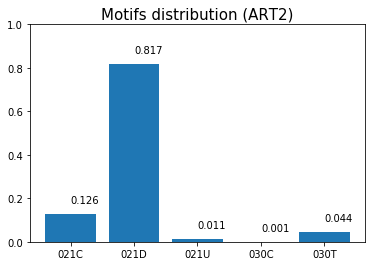

In [35]:
a = pd.Series(counter_art)
a = a/sum(a)
plt.title("Motifs distribution (ART2)", fontsize=15)
plt.ylim(0, 1)
plt.bar(a.index, a.values)
for key in a.keys():
    plt.text(x=key, y=a[key]+0.05,
             s=f"{a[key]:.3f}", fontsize=10)
plt.savefig("./pics/motif_distr_art2.png")

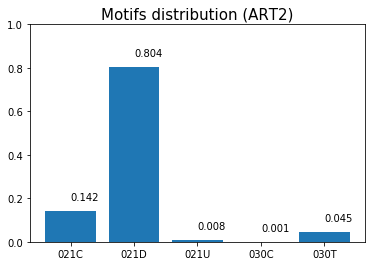

In [25]:
a = pd.Series(counter_art)
a = a/sum(a)
plt.title("Motifs distribution (ART2)", fontsize=15)
plt.ylim(0, 1)
plt.bar(a.index, a.values)
for key in a.keys():
    plt.text(x=key, y=a[key]+0.05,
             s=f"{a[key]:.3f}", fontsize=10)
plt.savefig("./pics/motif_distr_art2.png")

In [36]:
art_network_params = get_network_params(artificial_matrix, verbose=True)

TF content: 0.15333333333333332
Number of TG in motif distribution:
0    0.195212
1    0.804788
dtype: float64

Node patricipation distribution:
1.0    0.626667
3.0    0.106667
6.0    0.046667
2.0    0.026667
8.0    0.020000
dtype: float64

Unique nodes number distribution
0    0.826888
1    0.173112
2    0.000000
dtype: float64

Is edge unique? (for 1-unique node motifs)
False    1.0
dtype: float64

Distribution of X-unique edges motifs (for 0-unique nodes motifs)
0    442
1      4
2      3
3      0
dtype: int64
0    0.984410
1    0.008909
2    0.006682
3    0.000000
dtype: float64



In [26]:
art_network_params = get_network_params(artificial_matrix, verbose=True)

TF content: 0.14666666666666667
Number of TG in motif distribution:
0    0.182886
1    0.817114
dtype: float64

Node patricipation distribution:
1.0     0.613333
3.0     0.086667
6.0     0.053333
15.0    0.026667
2.0     0.020000
dtype: float64

Unique nodes number distribution
0    0.845638
1    0.154362
2    0.000000
dtype: float64

Is edge unique? (for 1-unique node motifs)
False    1.0
dtype: float64

Distribution of X-unique edges motifs (for 0-unique nodes motifs)
0    499
1      4
2      1
3      0
dtype: int64
0    0.990079
1    0.007937
2    0.001984
3    0.000000
dtype: float64



In [27]:
len(art_network_params.tf_nodes)/artificial_matrix.shape[0]

0.14666666666666667

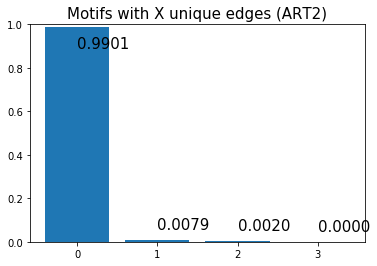

In [28]:
a = pd.Series({0: 499, 1: 4, 2: 1, 3: 0})
a = a/sum(a)
plt.title("Motifs with X unique edges (ART2)", fontsize=15)
plt.xticks(a.index)
plt.ylim(0, 1)
plt.bar(a.index, a.values)
for key in a.keys():
    plt.text(x=key, y=a[key]+0.05  - 0.15 * (key == 0),
             s=f"{a[key]:.4f}", fontsize=15)
plt.savefig("./pics/motif_by_unique_edges_art2.png")

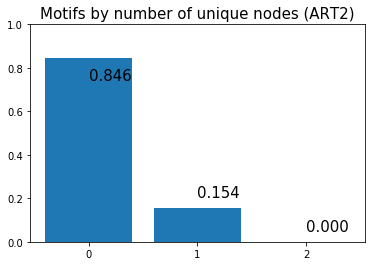

In [29]:
plt.xticks([0, 1, 2])
plt.ylim(0, 1)
plt.title("Motifs by number of unique nodes (ART2)", fontsize=15)
plt.bar(art_network_params.unique_nodes.index, art_network_params.unique_nodes.values)
for i in range(len(art_network_params.unique_nodes)):
    plt.text(x=i, y=art_network_params.unique_nodes[i]+0.05 - 0.15 * (i == 0),
             s=f"{art_network_params.unique_nodes[i]:.3f}", fontsize=15)
plt.savefig(f"./pics/motifs_by_uniqnodes_ART2.png")

Network finishing

In [23]:
test_network = deepcopy(artificial_matrix)

In [24]:
TARGET_SPARCITY = 3.6

In [25]:
n_nodes = test_network.shape[0]
n_links = int(test_network.sum())
print(f"Links: {n_links}\tNodes: {n_nodes}")
target_links_number = int(TARGET_SPARCITY*n_nodes)
print(f"Required number of links: {target_links_number}")
tf_total = np.where(test_network.sum(axis=0) != 0)[0]
tg_total = np.where(test_network.sum(axis=0) == 0)[0]
base_motif = f.build_motif_from_string("0 0 0 1 0 0 1 1 0")

Links: 440	Nodes: 150
Required number of links: 540


In [26]:
while test_network.sum() < target_links_number:
    # weights for TF by in-degree
    tf_weights_in = test_network[tf_total, :].sum(axis=1)
    # weights for TF by out-degree
    tf_weights_out = test_network[:, tf_total].sum(axis=0)
    tf_weights_out /= sum(tf_weights_out)
    # weights for TG by in-degree
    tg_weights_in = test_network[tg_total, :].sum(axis=1)
    tg_weights_in /= sum(tg_weights_in)
    tf_pair = np.random.choice(range(len(tf_total)), size=2, replace=False, p=tf_weights_out)
    probs = (tf_weights_in[tf_pair] + 1e6)/sum(tf_weights_in[tf_pair] + 1e6)
    tf_2_idx = np.random.choice(tf_pair, p=probs)
    tf_2 = tf_total[tf_2_idx]
    tf_1 = tf_total[[tf for tf in tf_pair if tf != tf_2_idx][0]]
    tg = np.random.choice(tg_total, p=tg_weights_in)
    triad = tf_1, tf_2, tg
    triad_matrix = test_network[np.ix_(triad, triad)]
#     print(triad)
#     print(triad_matrix)
    existing_links = np.concatenate([np.diag(triad_matrix, k=i) for i in range(3)]).astype(int)
#     print(existing_links)
#     print()
    if existing_links.sum() == 0:
        links_pattern = np.maximum.reduce([triad_matrix, base_motif])
#         print(links_pattern)
        test_network[np.ix_(triad, triad)] = links_pattern

In [27]:
n_nodes = test_network.shape[0]
n_links = int(test_network.sum())
print(f"Links: {n_links}\tNodes: {n_nodes}")

Links: 541	Nodes: 150


In [28]:
%%time
motifs, counter_art = f.motif_search(cfg, test_network, batch_size=10000)
motifs_art = motifs["030T"]
counter_art

CPU times: user 107 ms, sys: 72.6 ms, total: 180 ms
Wall time: 1.05 s


{'021C': 2343, '021D': 13680, '021U': 132, '030C': 32, '030T': 947}

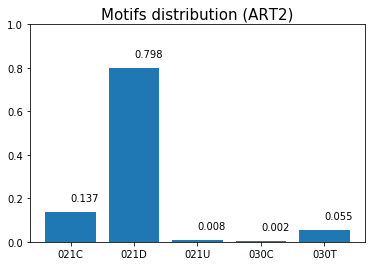

In [29]:
a = pd.Series(counter_art)
a = a/sum(a)
plt.title("Motifs distribution (ART2)", fontsize=15)
plt.ylim(0, 1)
plt.bar(a.index, a.values)
for key in a.keys():
    plt.text(x=key, y=a[key]+0.05,
             s=f"{a[key]:.3f}", fontsize=10)
plt.savefig("./pics/motif_distr_art2.png")

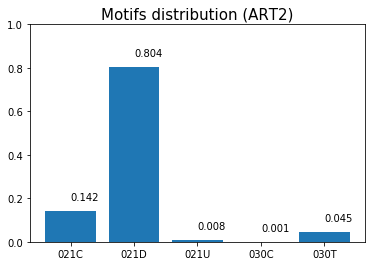

In [25]:
a = pd.Series(counter_art)
a = a/sum(a)
plt.title("Motifs distribution (ART2)", fontsize=15)
plt.ylim(0, 1)
plt.bar(a.index, a.values)
for key in a.keys():
    plt.text(x=key, y=a[key]+0.05,
             s=f"{a[key]:.3f}", fontsize=10)
plt.savefig("./pics/motif_distr_art2.png")

In [30]:
art_network_params = get_network_params(test_network, verbose=True)

TF content: 0.14666666666666667
Number of TG in motif distribution:
0    0.154171
1    0.845829
dtype: float64

Node patricipation distribution:
1.0     0.440000
6.0     0.120000
3.0     0.080000
8.0     0.033333
15.0    0.033333
dtype: float64

Unique nodes number distribution
0    0.930306
1    0.069694
2    0.000000
dtype: float64

Is edge unique? (for 1-unique node motifs)
False    1.0
dtype: float64

Distribution of X-unique edges motifs (for 0-unique nodes motifs)
0    875
1      6
2      0
3      0
dtype: int64
0    0.99319
1    0.00681
2    0.00000
3    0.00000
dtype: float64



In [26]:
art_network_params = get_network_params(artificial_matrix, verbose=True)

TF content: 0.14666666666666667
Number of TG in motif distribution:
0    0.182886
1    0.817114
dtype: float64

Node patricipation distribution:
1.0     0.613333
3.0     0.086667
6.0     0.053333
15.0    0.026667
2.0     0.020000
dtype: float64

Unique nodes number distribution
0    0.845638
1    0.154362
2    0.000000
dtype: float64

Is edge unique? (for 1-unique node motifs)
False    1.0
dtype: float64

Distribution of X-unique edges motifs (for 0-unique nodes motifs)
0    499
1      4
2      1
3      0
dtype: int64
0    0.990079
1    0.007937
2    0.001984
3    0.000000
dtype: float64



In [27]:
len(art_network_params.tf_nodes)/artificial_matrix.shape[0]

0.14666666666666667

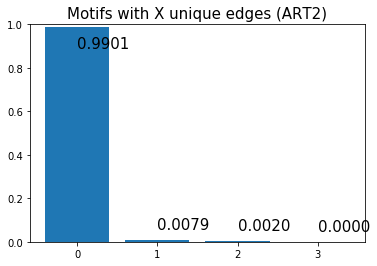

In [28]:
a = pd.Series({0: 499, 1: 4, 2: 1, 3: 0})
a = a/sum(a)
plt.title("Motifs with X unique edges (ART2)", fontsize=15)
plt.xticks(a.index)
plt.ylim(0, 1)
plt.bar(a.index, a.values)
for key in a.keys():
    plt.text(x=key, y=a[key]+0.05  - 0.15 * (key == 0),
             s=f"{a[key]:.4f}", fontsize=15)
plt.savefig("./pics/motif_by_unique_edges_art2.png")

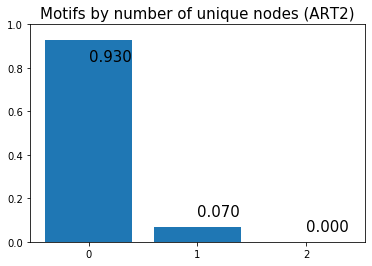

In [31]:
plt.xticks([0, 1, 2])
plt.ylim(0, 1)
plt.title("Motifs by number of unique nodes (ART2)", fontsize=15)
plt.bar(art_network_params.unique_nodes.index, art_network_params.unique_nodes.values)
for i in range(len(art_network_params.unique_nodes)):
    plt.text(x=i, y=art_network_params.unique_nodes[i]+0.05 - 0.15 * (i == 0),
             s=f"{art_network_params.unique_nodes[i]:.3f}", fontsize=15)
plt.savefig(f"./pics/motifs_by_uniqnodes_ART2.png")

In [35]:
joblib.dump(test_network, "test_network.gz")

['test_network.gz']

Motif enrichment

In [32]:
noise_list = np.linspace(0, 80000, 11).astype(int)
score_list = []
for noise in tqdm(noise_list):
    shuffled_matrix = f.get_shuffled_matrix(test_network, noise)
    score_list.append(1-f.corruption_score(test_network, shuffled_matrix))

100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


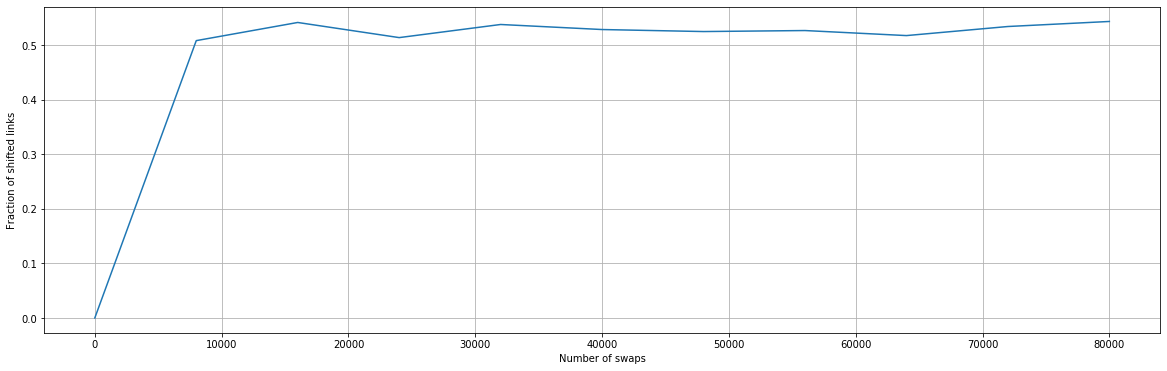

In [33]:
plt.figure(figsize=(20, 6))
plt.grid()
plt.ylabel("Fraction of shifted links")
plt.xlabel("Number of swaps")
plt.plot(noise_list, score_list);

In [8]:
test_network = joblib.load("test_network.gz")

In [12]:
%%time
motifs, counter_art = f.motif_search(cfg, test_network, batch_size=10000)
motifs_art = motifs["030T"]
counter_art

CPU times: user 115 ms, sys: 78.7 ms, total: 194 ms
Wall time: 963 ms


{'021C': 2343, '021D': 13680, '021U': 132, '030C': 32, '030T': 947}

In [9]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 10000
counters = f.generate_random_networks(cfg, test_network, N_SIMS, N_STEPS, N_SWAPS)

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


In [10]:
joblib.dump(counters, "./shuffled_counters_2.gz");

In [11]:
counters = joblib.load("./shuffled_counters_2.gz");

100%|██████████| 1000/1000 [00:05<00:00, 189.56it/s]


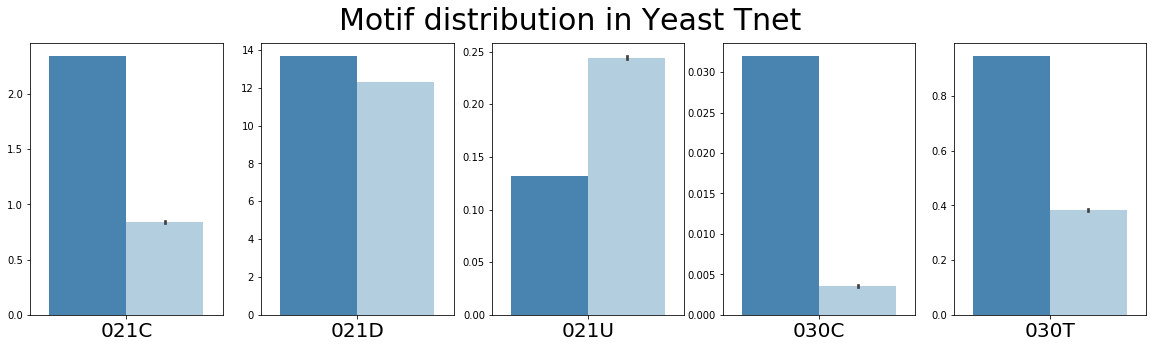

In [13]:
f.plot_distr(counters, counter_art, label="Motif distribution in Yeast Tnet", highlight=False);

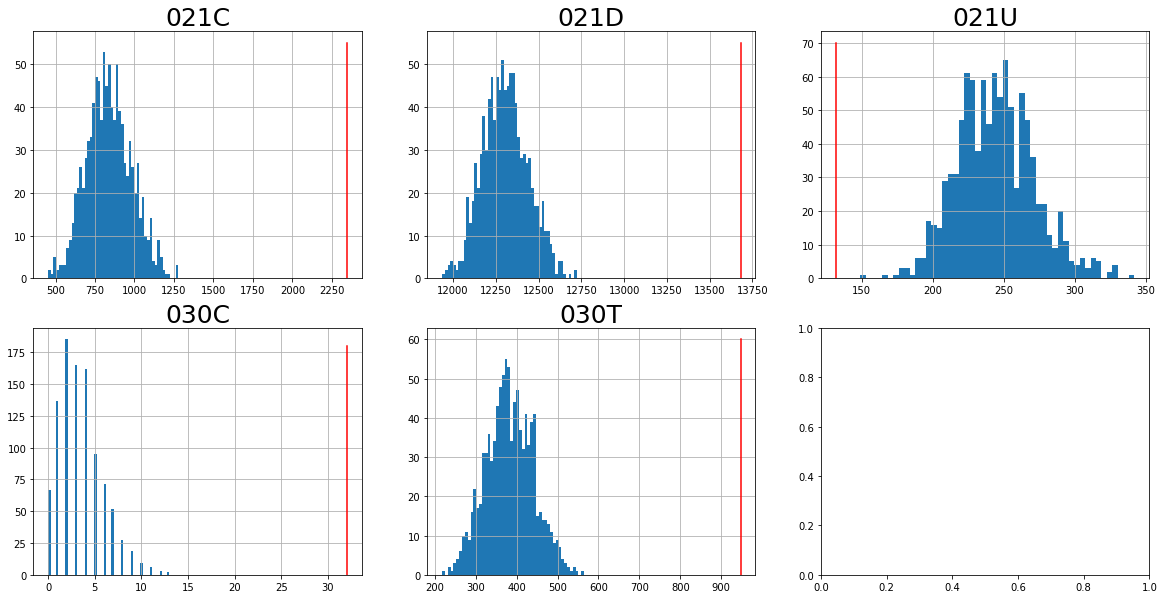

In [15]:
f.plot_distr_2(counters, counter_art, ticks = [55, 55, 70, 180, 60])

In [16]:
f.build_zscores_report(counters, counter_art)

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,2343,839.212,140.585,10.6966,0,< 0.01
021D,13680,12304.1,132.333,10.3974,0,< 0.01
021U,132,244.225,27.1459,-4.13414,0,< 0.01
030C,32,3.52,2.38864,11.9231,0,< 0.01
030T,947,382.85,57.622,9.79053,0,< 0.01


In [17]:
D = nx.DiGraph(test_network)

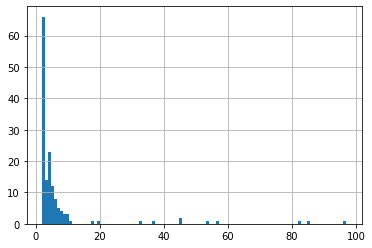

In [18]:
pd.Series(dict(nx.degree(D))).hist(bins=100);

In [19]:
nx.diameter(D.to_undirected()), nx.radius(D.to_undirected())

(3, 2)

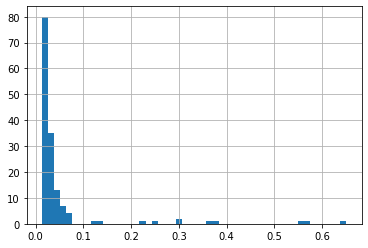

In [20]:
pd.Series(nx.degree_centrality(D)).hist(bins=50);

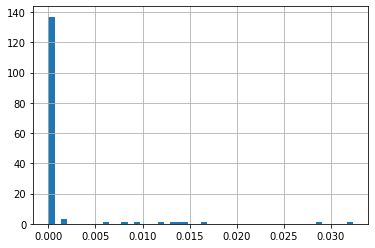

In [21]:
pd.Series(nx.betweenness_centrality(D)).hist(bins=50);

In [24]:
D = nx.DiGraph(artificial_matrix)

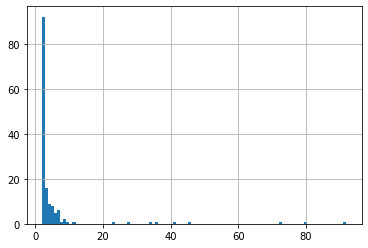

In [25]:
pd.Series(dict(nx.degree(D))).hist(bins=100);

In [26]:
nx.diameter(D.to_undirected()), nx.radius(D.to_undirected())

(3, 2)

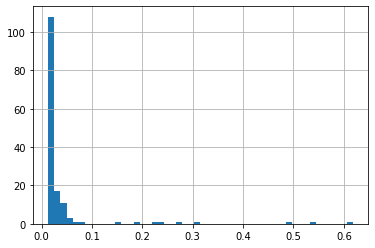

In [27]:
pd.Series(nx.degree_centrality(D)).hist(bins=50);

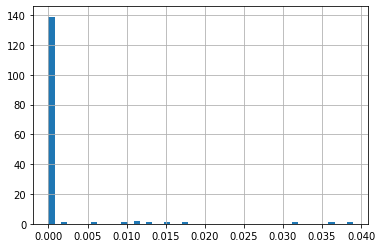

In [28]:
pd.Series(nx.betweenness_centrality(D)).hist(bins=50);

Real network parameters

In [36]:
interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

((1201, 1201), 4326.0)

In [37]:
4326/1201

3.6019983347210656

In [38]:
%%time
motifs, counter_orig = f.motif_search(cfg, interaction_matrix_ffl, batch_size=10000)
motifs_real = motifs["030T"]
counter_orig

CPU times: user 445 ms, sys: 94.3 ms, total: 540 ms
Wall time: 2.66 s


{'021C': 12874, '021D': 170539, '021U': 6906, '030C': 8, '030T': 3370}

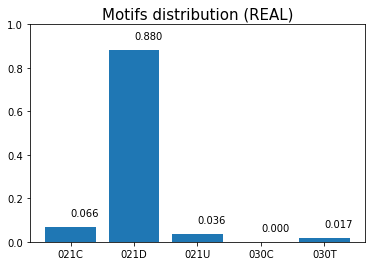

In [39]:
a = pd.Series(counter_orig)
a = a/sum(a)
plt.title("Motifs distribution (REAL)", fontsize=15)
plt.ylim(0, 1)
plt.bar(a.index, a.values)
for key in a.keys():
    plt.text(x=key, y=a[key]+0.05,
             s=f"{a[key]:.3f}", fontsize=10)
plt.savefig("./pics/motif_distr_real.png")

In [40]:
real_network_params = get_network_params(interaction_matrix_ffl, verbose=True)

Number of TG in motif distribution:
0    0.049555
1    0.950445
dtype: float64

Node patricipation distribution:
1.0    0.457952
2.0    0.175687
3.0    0.094088
4.0    0.048293
5.0    0.034138
dtype: float64

Unique nodes number distribution
0    0.837685
1    0.161424
2    0.000890
dtype: float64

Is edge unique? (for 1-unique node motifs)
False    0.968153
True     0.031847
dtype: float64

Distribution of X-unique edges motifs (for 0-unique nodes motifs)
0    1545
1    1042
2     230
3       6
dtype: int64
0    0.547290
1    0.369111
2    0.081474
3    0.002125
dtype: float64



In [41]:
print(f"TF fractioin: {len(real_network_params.tf_nodes)/interaction_matrix_ffl.shape[0]}")

TF fractioin: 0.10241465445462115


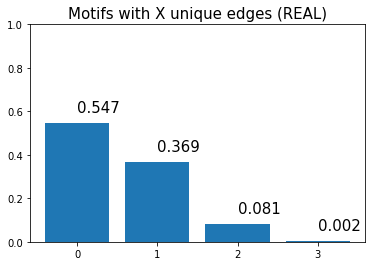

In [30]:
a = pd.Series({0: 1545, 1: 1042, 2: 230, 3: 6})
a = a/sum(a)
plt.title("Motifs with X unique edges (REAL)", fontsize=15)
plt.xticks(a.index)
plt.ylim(0, 1)
plt.bar(a.index, a.values)
for key in a.keys():
    plt.text(x=key, y=a[key]+0.05,
             s=f"{a[key]:.3f}", fontsize=15)
plt.savefig("./pics/motif_by_unique_edges_real.png")

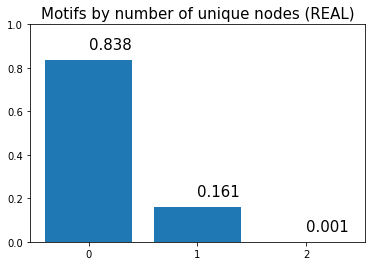

In [89]:
plt.xticks([0, 1, 2])
plt.ylim(0, 1)
plt.title("Motifs by number of unique nodes (REAL)", fontsize=15)
plt.bar(real_network_params.unique_nodes.index, real_network_params.unique_nodes.values)
for i in range(len(real_network_params.unique_nodes)):
    plt.text(x=i, y=real_network_params.unique_nodes[i]+0.05,
             s=f"{real_network_params.unique_nodes[i]:.3f}", fontsize=15)
plt.savefig(f"./pics/motifs_by_uniqnodes_REAL.png")